

Ce notebook a pour objectif d'analyser les données d'inflation provenant de la base `datahub.io/core/inflation`.  
Les données ont été stockées dans **MinIO** et seront récupérées via l’API **boto3**, puis traitées avec **pandas**.  
L’objectif est d’observer l’évolution de l’inflation mondiale sur plusieurs années.

---


In [13]:
import boto3
from botocore.exceptions import ClientError

# Connexion au client MinIO
s3 = boto3.client(
    's3',
    endpoint_url='http://localhost:9000',  # ou 'http://minio:9000' si dans le conteneur Jupyter
    aws_access_key_id='minioadmin',
    aws_secret_access_key='minioadmin',
    config=boto3.session.Config(signature_version='s3v4'),
    region_name='us-east-1'
)

# Créer le bucket si pas existant
bucket_name = 'inflation'
try:
    s3.head_bucket(Bucket=bucket_name)
    print(f"Le bucket '{bucket_name}' existe déjà.")
except ClientError:
    print(f"Le bucket '{bucket_name}' n'existe pas. Création en cours...")
    s3.create_bucket(Bucket=bucket_name)
    print(f"Bucket '{bucket_name}' créé.")

# Uploader le fichier inflation_data.csv dans le bucket
file_path = '../data/inflation_data.csv'  # adapte selon ton chemin réel

try:
    s3.upload_file(file_path, bucket_name, 'inflation_data.csv')
    print("Fichier uploadé avec succès.")
except Exception as e:
    print("Erreur lors de l'upload:", e)


Le bucket 'inflation' n'existe pas. Création en cours...
Bucket 'inflation' créé.
Fichier uploadé avec succès.


In [15]:
response = s3.list_buckets()
print([b['Name'] for b in response['Buckets']])


['inflation']


In [18]:
import boto3
import pandas as pd
from io import BytesIO

# Connexion au service MinIO (ajuste endpoint_url selon ton contexte)
s3 = boto3.client(
    's3',
    endpoint_url='http://localhost:9000',
    aws_access_key_id='minioadmin',
    aws_secret_access_key='minioadmin',
    config=boto3.session.Config(signature_version='s3v4'),
    region_name='us-east-1'
)


In [20]:
# Récupération du fichier inflation_data.csv depuis le bucket 'inflation'
obj = s3.get_object(Bucket='inflation', Key='inflation_data.csv')

# Lecture du contenu dans un DataFrame pandas
data = pd.read_csv(BytesIO(obj['Body'].read()))

# Afficher un aperçu des données
data.head()


,Country,Country Code,Year,Inflation
0,Afghanistan,AFG,2005,12.686269
1,Afghanistan,AFG,2006,6.784597
2,Afghanistan,AFG,2007,8.680571
3,Afghanistan,AFG,2008,26.418664
4,Afghanistan,AFG,2009,-6.811161


# Analyse des données d'inflation

Ce dataset contient les taux d'inflation mensuels par pays sur plusieurs années.  
Nous allons commencer par un aperçu général des variables et des tendances.

- Nombre de lignes : `data.shape[0]`
- Colonnes principales : liste des colonnes dans `data.columns`

Ensuite, on visualisera la tendance d’inflation pour un pays donné, par exemple le Senegal.


In [24]:
# Statistiques globales
data.describe()


,Year,Inflation
count,11039.000000,11039.000000
mean,1997.128725,19.825504
std,16.961565,288.054102
min,1960.000000,-17.640424
25%,1984.000000,2.409180
50%,1999.000000,4.944324
75%,2011.000000,9.702161
max,2023.000000,23773.131774


In [30]:
print(data.columns.tolist())


['Country', 'Country Code', 'Year', 'Inflation']


In [34]:
data['Date'] = pd.to_datetime(data['Year'].astype(str) + '-01-01')


In [36]:
senegal_data = data[data['Country'] == 'Senegal']


 Évolution de l'inflation au Sénégal

Dans cette section, nous analysons l'évolution du taux d'inflation au Sénégal sur la période couverte par les données.  
Nous allons filtrer les données pour ne conserver que celles correspondant au Sénégal, puis visualiser la tendance à l'aide d'une courbe.  
La colonne `Year` est convertie en format `Date` pour une représentation temporelle correcte sur l'axe des X.


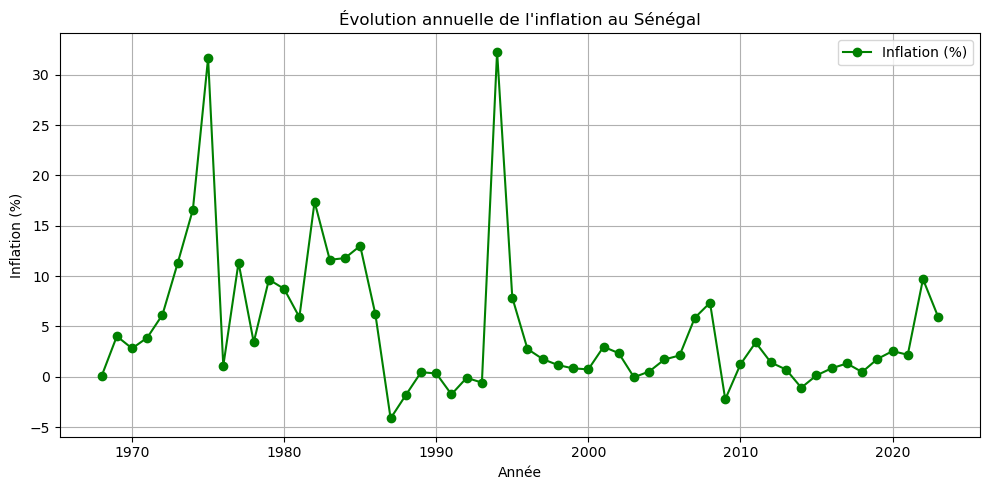

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(
  senegal_data['Date'],
  senegal_data['Inflation'],
  marker='o',
  linestyle='-',
  color='green',
  label="Inflation (%)"
)
plt.title("Évolution annuelle de l'inflation au Sénégal")
plt.xlabel("Année")
plt.ylabel("Inflation (%)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


 Comparaison de l'inflation au Sénégal, Mali, Mauritanie, Gambie et Guinée

Dans cette section, nous comparons l'évolution du taux d'inflation sur plusieurs années pour cinq pays d'Afrique de l'Ouest :  
- Sénégal  
- Mali  
- Mauritanie  
- Gambie  
- Guinée  

L’objectif est de mettre en évidence les dynamiques économiques régionales et les écarts éventuels de stabilité monétaire.


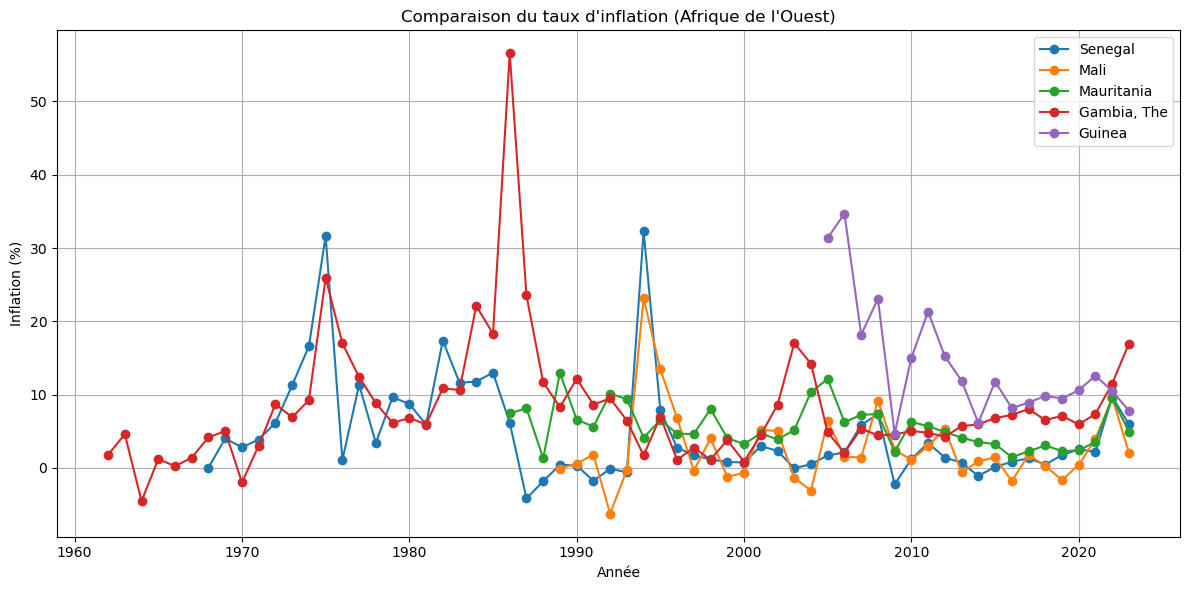

In [42]:
pays_a_comparer = ['Senegal', 'Mali', 'Mauritania', 'Gambia, The', 'Guinea']
plt.figure(figsize=(12, 6))

for pays in pays_a_comparer:
    subset = data[data['Country'] == pays]
    plt.plot(subset['Year'], subset['Inflation'], marker='o', label=pays)

plt.title('Comparaison du taux d\'inflation (Afrique de l\'Ouest)')
plt.xlabel('Année')
plt.ylabel('Inflation (%)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


 📊 Analyse agrégée par pays

Dans cette section, nous extrayons des indicateurs clés pour 5 pays d'Afrique de l'Ouest :
le Sénégal, le Mali, la Mauritanie, la Gambie et la Guinée.  
Ces indicateurs sont :
- La moyenne du taux d'inflation
- L'écart-type (volatilité)
- Le taux d'inflation le plus élevé
- La dernière année disponible dans les données

Ces agrégats nous permettent de mieux comparer les pays et d'identifier des tendances ou des anomalies.


In [44]:
# Liste des pays à analyser
pays_cibles = ['Senegal', 'Mali', 'Mauritania', 'Gambia, The', 'Guinea']

# Filtrer les données
data_filtrée = data[data['Country'].isin(pays_cibles)]

# Créer le résumé par pays
insights_df = data_filtrée.groupby('Country').agg(
    Moyenne_Inflation=('Inflation', 'mean'),
    Ecart_Type=('Inflation', 'std'),
    Max_Inflation=('Inflation', 'max'),
    Dernière_Année=('Year', 'max')
).reset_index()

# Afficher les insights
insights_df


,Country,Moyenne_Inflation,Ecart_Type,Max_Inflation,Dernière_Année
0,"Gambia, The",8.207528,8.568705,56.560172,2023
1,Guinea,14.278284,8.179071,34.695271,2023
2,Mali,2.673264,5.250511,23.176791,2023
3,Mauritania,5.619717,2.903588,12.932682,2023
4,Senegal,4.774890,7.076817,32.293667,2023


💾 Sauvegarde des insights dans MinIO

Les données agrégées ont été converties en fichier CSV et stockées dans le bucket `insights` sur MinIO.
Ce fichier contient une synthèse par pays : moyenne, écart-type, maximum et dernière année.

Cela permet de conserver une trace de nos analyses prêtes à être consommées par d'autres applications ou dashboards.


In [48]:
import boto3
from io import BytesIO
from botocore.exceptions import ClientError
from boto3.session import Config

# Reconnexion à MinIO
s3 = boto3.client(
    's3',
    endpoint_url='http://localhost:9000',
    aws_access_key_id='minioadmin',
    aws_secret_access_key='minioadmin',
    config=Config(signature_version='s3v4'),
    region_name='us-east-1'
)

# Nom du bucket pour les résultats
bucket_name = 'insights'
object_name = 'insights_par_pays.csv'

# Création du bucket si non existant
try:
    s3.head_bucket(Bucket=bucket_name)
except ClientError:
    s3.create_bucket(Bucket=bucket_name)

# Conversion en CSV (en mémoire)
csv_buffer = BytesIO()
insights_df.to_csv(csv_buffer, index=False)

# Upload dans MinIO
s3.put_object(Bucket=bucket_name, Key=object_name, Body=csv_buffer.getvalue())

print(f"✅ Fichier '{object_name}' sauvegardé dans le bucket '{bucket_name}'.")


✅ Fichier 'insights_par_pays.csv' sauvegardé dans le bucket 'insights'.


 📊 Visualisation comparative de l'inflation annuelle

Le graphique ci-dessous présente l'évolution du taux d'inflation pour cinq pays d'Afrique de l'Ouest.  
Cette comparaison permet d'identifier les tendances et divergences économiques régionales.


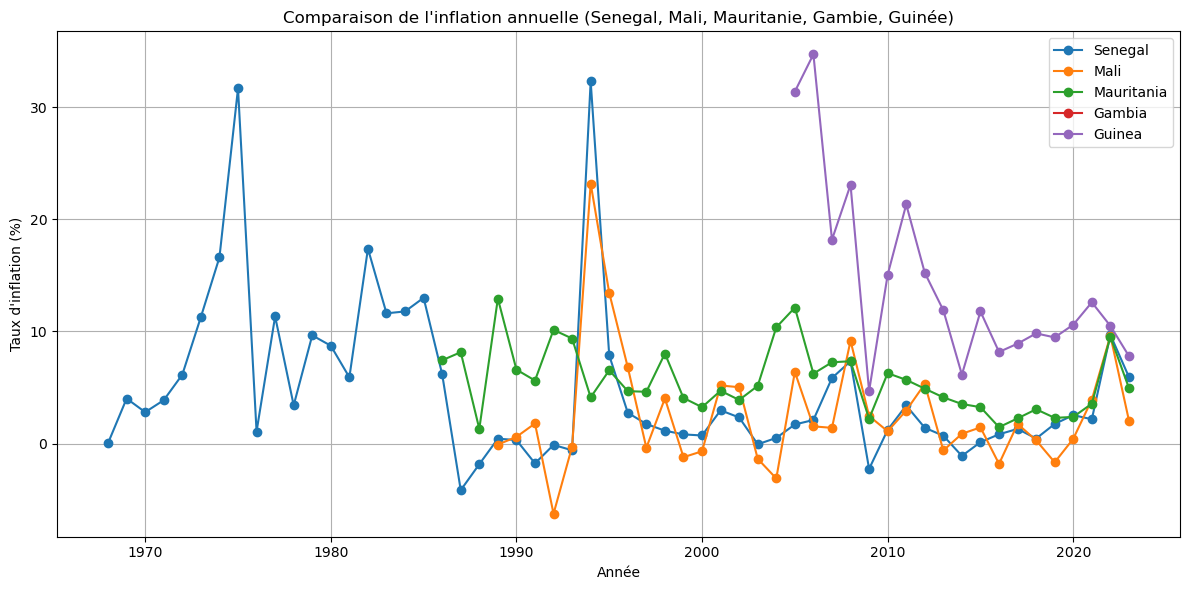

In [51]:
import matplotlib.pyplot as plt

# Liste des pays ciblés
pays_cibles = ['Senegal', 'Mali', 'Mauritania', 'Gambia', 'Guinea']

# Filtrer les données pour ces pays
df_filtré = data[data['Country'].isin(pays_cibles)]

plt.figure(figsize=(12, 6))

for pays in pays_cibles:
    pays_data = df_filtré[df_filtré['Country'] == pays]
    plt.plot(pays_data['Year'], pays_data['Inflation'], marker='o', label=pays)

plt.title("Comparaison de l'inflation annuelle (Senegal, Mali, Mauritanie, Gambie, Guinée)")
plt.xlabel("Année")
plt.ylabel("Taux d'inflation (%)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [14]:
import boto3

s3 = boto3.client(
    's3',
    endpoint_url='http://localhost:9000',  # localhost ici
    aws_access_key_id='minioadmin',
    aws_secret_access_key='minioadmin',
    region_name='us-east-1',
    config=boto3.session.Config(signature_version='s3v4')
)


In [18]:
import pandas as pd
from io import BytesIO

# Lire les données dans un DataFrame
obj = s3.get_object(Bucket='inflation', Key='inflation_data.csv')
data = pd.read_csv(BytesIO(obj['Body'].read()))

# Filtrer et analyser par pays, par exemple Sénégal
pays_cible = ['Senegal', 'Mali', 'Mauritania', 'Gambia', 'Guinea']
data_cible = data[data['Country'].isin(pays_cible)]

# Exemple : moyenne inflation par pays
moyennes = data_cible.groupby('Country')['Inflation'].mean().sort_values(ascending=False)
print(moyennes)

# Puis tu peux sauvegarder ce DataFrame ou un fichier csv dans le bucket 'insights'
csv_buffer = BytesIO()
moyennes.to_csv(csv_buffer)
csv_buffer.seek(0)

s3.put_object(Bucket='insights', Key='moyenne_inflation.csv', Body=csv_buffer.getvalue())
print("Fichier moyenne_inflation.csv sauvegardé dans bucket 'insights'.")


Country
Guinea        14.278284
Mauritania     5.619717
Senegal        4.774890
Mali           2.673264
Name: Inflation, dtype: float64
Fichier moyenne_inflation.csv sauvegardé dans bucket 'insights'.


In [20]:
import pandas as pd
from io import BytesIO

# Récupérer l'objet depuis MinIO
obj = s3.get_object(Bucket='inflation', Key='inflation_data.csv')

# Charger dans pandas
data = pd.read_csv(BytesIO(obj['Body'].read()))

# Afficher les premières lignes pour vérifier
print(data.head())


       Country Country Code  Year  Inflation
0  Afghanistan          AFG  2005  12.686269
1  Afghanistan          AFG  2006   6.784597
2  Afghanistan          AFG  2007   8.680571
3  Afghanistan          AFG  2008  26.418664
4  Afghanistan          AFG  2009  -6.811161


Extraction des Insights

L'objectif est d'extraire des informations agrégées pertinentes à partir des données sources.  
Ici, nous calculons la moyenne annuelle du taux d'inflation pour les pays ciblés : Sénégal, Mali, Mauritanie, Gambie et Guinée.

Ce calcul permettra de mieux comprendre les tendances inflationnistes par pays sur la période analysée.


In [25]:
# Liste des pays ciblés
pays_cibles = ['Senegal', 'Mali', 'Mauritania', 'Gambia', 'Guinea']

# Filtrer les données pour ces pays
data_filtrée = data[data['Country'].isin(pays_cibles)]

# Calcul de la moyenne d'inflation par pays
insights = data_filtrée.groupby('Country')['Inflation'].mean().reset_index()

# Renommer pour plus de clarté
insights.rename(columns={'Inflation': 'Inflation_moyenne'}, inplace=True)

print(insights)


      Country  Inflation_moyenne
0      Guinea          14.278284
1        Mali           2.673264
2  Mauritania           5.619717
3     Senegal           4.774890


Sauvegarde des insights dans MinIO

Dans cette étape, on va convertir notre DataFrame `insights` (contenant les moyennes d'inflation par pays) en format CSV en mémoire, puis écrire ce fichier CSV directement dans le bucket `insights` de MinIO via l'API S3 compatible.  
Cela permet de respecter la consigne de sauvegarde des résultats sur le stockage objet.


In [27]:
import io

# Convertir le DataFrame en CSV dans un buffer mémoire
csv_buffer = io.StringIO()
insights.to_csv(csv_buffer, index=False)

# Écriture dans MinIO (S3 compatible)
s3.put_object(
    Bucket='insights',                # Le bucket où stocker
    Key='average_inflation.csv',     # Le nom du fichier
    Body=csv_buffer.getvalue()       # Le contenu CSV
)

print("Insights sauvegardés dans MinIO sous 'insights/average_inflation.csv'")


Insights sauvegardés dans MinIO sous 'insights/average_inflation.csv'


 Vérification de la sauvegarde et lecture du fichier CSV depuis MinIO

On va lire le fichier `average_inflation.csv` directement depuis MinIO pour vérifier que la sauvegarde s’est bien passée et pour pouvoir utiliser les insights sauvegardés dans d’autres traitements.


In [33]:
# Lecture du fichier CSV depuis MinIO
obj = s3.get_object(Bucket='insights', Key='average_inflation.csv')
csv_content = obj['Body'].read().decode('utf-8')

# Conversion en DataFrame pandas
import pandas as pd
df_insights = pd.read_csv(io.StringIO(csv_content))

print(df_insights.head())


      Country  Inflation_moyenne
0      Guinea          14.278284
1        Mali           2.673264
2  Mauritania           5.619717
3     Senegal           4.774890


 Insight : Moyenne d'inflation par décennie

Cet insight vise à comparer l’évolution moyenne de l’inflation par pays sur les décennies suivantes :
- 2000–2009
- 2010–2019
- 2020–2022

Cela permet d’identifier si l’inflation augmente, baisse ou reste stable dans chaque pays.


In [44]:
import pandas as pd

# S'assurer qu'on travaille bien sur les bons pays
pays = ['Senegal', 'Mali', 'Mauritania', 'Gambia', 'Guinea']
df_filtered = data[data['Country'].isin(pays)]

# Ajouter une colonne "Décennie"
def get_decade(year):
    if 2000 <= year <= 2009:
        return '2000-2009'
    elif 2010 <= year <= 2019:
        return '2010-2019'
    elif 2020 <= year <= 2022:
        return '2020-2022'
    else:
        return 'Autre'

df_filtered['Décennie'] = df_filtered['Year'].apply(get_decade)

# Moyenne inflation par pays et par décennie
tendances = df_filtered.groupby(['Country', 'Décennie'])['Inflation'].mean().reset_index()
tendances = tendances.pivot(index='Country', columns='Décennie', values='Inflation').round(2)
display(tendances)


/var/folders/zv/3wn1vmp13rz_dnc8g45hjh880000gn/T/ipykernel_61450/2977817426.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Décennie'] = df_filtered['Year'].apply(get_decade)


Décennie,2000-2009,2010-2019,2020-2022,Autre
Country,,,,
Guinea,22.40,11.78,11.23,7.80
Mali,2.61,0.97,4.66,3.65
Mauritania,6.26,3.69,5.16,6.57
Senegal,2.13,1.02,4.81,6.71


Insight 2 – Comparaison des inflations moyennes entre 2018 et 2022

Cet insight analyse les taux moyens d'inflation pour les pays ciblés (Sénégal, Mali, Mauritanie, Gambie, Guinée) sur les 5 dernières années (2018–2022).  
Objectif : identifier les pays ayant subi les plus fortes pressions inflationnistes récemment.


In [49]:
# Liste des pays ciblés
pays = ['Senegal', 'Mali', 'Mauritania', 'Gambia', 'Guinea']

# Filtrer les données pour ces pays
selected_data = data[data['Country'].isin(pays)]


In [53]:
import boto3
from io import BytesIO
import pandas as pd

# Configuration MinIO
s3 = boto3.client(
    's3',
    endpoint_url='http://localhost:9000',
    aws_access_key_id='minioadmin',
    aws_secret_access_key='minioadmin',
    region_name='us-east-1'
)

# Charger le fichier depuis le bucket "inflation"
obj = s3.get_object(Bucket='inflation', Key='inflation_data.csv')
data = pd.read_csv(BytesIO(obj['Body'].read()))

# Vérif rapide
data.head()


,Country,Country Code,Year,Inflation
0,Afghanistan,AFG,2005,12.686269
1,Afghanistan,AFG,2006,6.784597
2,Afghanistan,AFG,2007,8.680571
3,Afghanistan,AFG,2008,26.418664
4,Afghanistan,AFG,2009,-6.811161


Inflation moyenne (2018-2022) par pays :
Country
Guinea        10.597915
Mauritania     4.168716
Senegal        3.328277
Mali           2.525289
Name: Inflation, dtype: float64


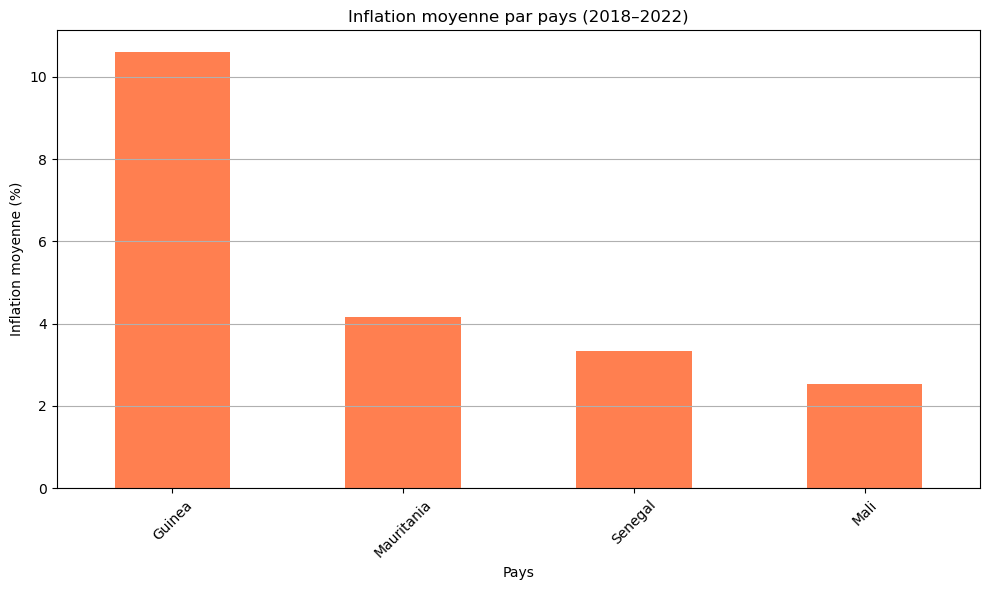

In [55]:
# Filtrer les données entre 2018 et 2022
df_recent = selected_data[(selected_data['Year'] >= 2018) & (selected_data['Year'] <= 2022)]

# Calcul des moyennes par pays
recent_means = df_recent.groupby('Country')['Inflation'].mean().sort_values(ascending=False)

# Affichage
print("Inflation moyenne (2018-2022) par pays :")
print(recent_means)

# Visualisation
plt.figure(figsize=(10,6))
recent_means.plot(kind='bar', color='coral')
plt.title("Inflation moyenne par pays (2018–2022)")
plt.xlabel("Pays")
plt.ylabel("Inflation moyenne (%)")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [65]:
import boto3
import pandas as pd
import io

s3 = boto3.client(
    's3',
    endpoint_url='http://localhost:9000',
    aws_access_key_id='minioadmin',
    aws_secret_access_key='minioadmin',
    region_name='us-east-1',
)

response = s3.get_object(Bucket='inflation', Key='inflation_data.csv')
data = pd.read_csv(io.BytesIO(response['Body'].read()))


In [67]:
import pandas as pd

# 1. Sélectionner les pays à analyser
pays = ['Senegal', 'Mali', 'Mauritania', 'Gambia', 'Guinea']
df = data[data['Country'].isin(pays)]

# 2. Filtrer les années récentes
df_recent = df[(df['Year'] >= 2018) & (df['Year'] <= 2022)]

# 3. Calculer les moyennes d’inflation par pays
moyennes = df_recent.groupby('Country')['Inflation'].mean().sort_values(ascending=False).round(2)

# 4. Générer le contenu Markdown
markdown_content = "# Rapport d’Inflation Moyenne (2018–2022)\n\n"
markdown_content += "| Pays | Inflation Moyenne (%) |\n"
markdown_content += "|------|------------------------|\n"
for country, value in moyennes.items():
    markdown_content += f"| {country} | {value} |\n"

print(markdown_content)


# Rapport d’Inflation Moyenne (2018–2022)

| Pays | Inflation Moyenne (%) |
|------|------------------------|
| Guinea | 10.6 |
| Mauritania | 4.17 |
| Senegal | 3.33 |
| Mali | 2.53 |



### Upload du rapport Markdown dans MinIO (bucket: insights)

In [74]:
# (Re)générer et sauvegarder le fichier markdown localement
with open("rapport_inflation_2018_2022.md", "w", encoding="utf-8") as f:
    f.write(markdown_content)

print("📄 Fichier 'rapport_inflation_2018_2022.md' créé localement.")


📄 Fichier 'rapport_inflation_2018_2022.md' créé localement.


In [76]:
# Upload vers MinIO après avoir généré le fichier
with open("rapport_inflation_2018_2022.md", "rb") as f:
    s3.put_object(
        Bucket="insights",
        Key="rapport_inflation_2018_2022.md",
        Body=f,
        ContentType="text/markdown"
    )

print("✅ Rapport markdown uploadé avec succès dans le bucket 'insights'.")


✅ Rapport markdown uploadé avec succès dans le bucket 'insights'.


## Analyse des pays à plus forte inflation moyenne (2018-2022)

Nous allons identifier les pays ayant connu la plus forte inflation en moyenne entre 2018 et 2022, puis observer leur évolution annuelle pour détecter des tendances.


In [81]:
# Filtrer les données entre 2018 et 2022
df_recent = data[(data['Year'] >= 2018) & (data['Year'] <= 2022)]

# Calcul des moyennes par pays
recent_means = df_recent.groupby('Country')['Inflation'].mean().sort_values(ascending=False)

# Top 5 pays à plus forte inflation moyenne
top5_pays = recent_means.head(5).index.tolist()
df_top5 = df_recent[df_recent['Country'].isin(top5_pays)]

# Création du contenu Markdown dynamique
markdown_tendances = "## Tendances de l'inflation (2018-2022)\n\n"
markdown_tendances += "### Pays à plus forte inflation moyenne :\n"
markdown_tendances += "\n".join([f"- {pays} ({recent_means[pays]:.2f}%)" for pays in top5_pays])
markdown_tendances += "\n\n### Détails par année :\n"

for pays in top5_pays:
    markdown_tendances += f"\n#### {pays}\n"
    df_pays = df_top5[df_top5['Country'] == pays].sort_values('Year')
    for _, row in df_pays.iterrows():
        markdown_tendances += f"- {int(row['Year'])} : {row['Inflation']:.2f}%\n"

# Écriture du rapport Markdown
with open("tendances_inflation.md", "w", encoding="utf-8") as f:
    f.write(markdown_tendances)

print("📄 Rapport 'tendances_inflation.md' généré avec succès.")


📄 Rapport 'tendances_inflation.md' généré avec succès.


In [83]:
# Upload du deuxième rapport dans MinIO
with open("tendances_inflation.md", "rb") as f:
    s3.put_object(
        Bucket="insights",
        Key="tendances_inflation.md",
        Body=f,
        ContentType="text/markdown"
    )

print("✅ Rapport 'tendances_inflation.md' uploadé dans MinIO.")


✅ Rapport 'tendances_inflation.md' uploadé dans MinIO.
